After a recent meeting with Stephen discusing the strenghts and failings of different multiple comparisosns corrections
and mean significance policies, It became clear that perhaps taking the grand mean across multiple dprimes (with the
caveat of them being flipped to be positive), might not be the best options. Rather we could focus on individual cell
and context_pair/probe combinations, making some clasification based on their nature.

1. for a cell, for a probe, find all context_pairs and classify them as
    * silence - self
    * silence _ different [1,2,3]
    * self - different [1,2,3]
    * different [1,2] - different [2,3]
    * in total 10 different context_pairs classified into 4 groups
2. repeat for each probe
4. count only signficant dprimes, report the metric. and mean the metric across categories
5. report the mean and the proportion of significant dprimes.

In [80]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map

In [20]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':False,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)


In [21]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path('../data/210302_consolidated_summary_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'permutations'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
ff_corr = DF.mult_comp_corr.isin(['time', 'consecutive_2', 'consecutive_3'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr, good_cols]


filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
# filtered['id_probe'] = filtered[['id', 'probe']].agg('_'.join, axis=1)
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

print('duplicated columns?: ', any(filtered.loc[:,[col for col in filtered.columns if col !='value']].duplicated()))

duplicated columns?:  False


In [22]:
# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'sile'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'self_sile')] = 'sile_self'
comp_name_arr[np.where(comp_name_arr == 'diff_sile')] = 'sile_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'


filtered['trans_pair'] = comp_name_arr
classDF = filtered

# counts significant comparisons across clasifications

In [23]:
def nozero_nanmean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def percent_good(arr):
    total = np.sum(~np.isnan(arr))
    goods = np.sum(arr > 0)
    return goods/total * 100


print(classDF.columns)
# columns to aggregate are probe and trans_pair.
ord_cols = ['analysis', 'mult_comp_corr', 'id', 'trans_pair', 'probe', 'metric', 'value']
good_cols = [col for col in ord_cols if col not in ['value']]
print('duplicates?: ', np.any(classDF.loc[:, good_cols].duplicated()))
pivot_idx = [col for col in good_cols if col not in ['value', 'metric', 'probe']]
meanDF = classDF.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc=nozero_nanmean)
countDF = classDF.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc=percent_good)

Index(['analysis', 'mult_comp_corr', 'region', 'context_pair', 'probe',
       'metric', 'value', 'id', 'trans_pair'],
      dtype='object')
duplicates?:  True


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [24]:
# count DF shows consisten count between metrics, as it should. Take one of those colums and put it alongside the mean
# values
percent = countDF.drop(columns=['significant_abs_mass_center', 'significant_abs_mean']
                       ).rename(columns={'significant_abs_sum':'percentage'})
aggDF = pd.concat([meanDF, percent], axis=1)
aggDF = aggDF.reset_index().dropna()
aggDF.head(5)



metric,analysis,mult_comp_corr,id,trans_pair,significant_abs_mass_center,significant_abs_mean,significant_abs_sum,percentage
6,SC,consecutive_2,AMT020a-04-1,sile_diff,148.942986,0.933582,62.238810,16.666667
12,SC,consecutive_2,AMT020a-08-1,diff_diff,330.371918,1.079157,83.977793,25.000000
13,SC,consecutive_2,AMT020a-08-1,same_diff,38.951479,0.962825,64.188337,25.000000
15,SC,consecutive_2,AMT020a-08-1,sile_same,16.091269,0.789249,52.616578,25.000000
24,SC,consecutive_2,AMT020a-16-2,diff_diff,58.880287,1.119843,100.876033,25.000000


# check difference between dprime integral or mean

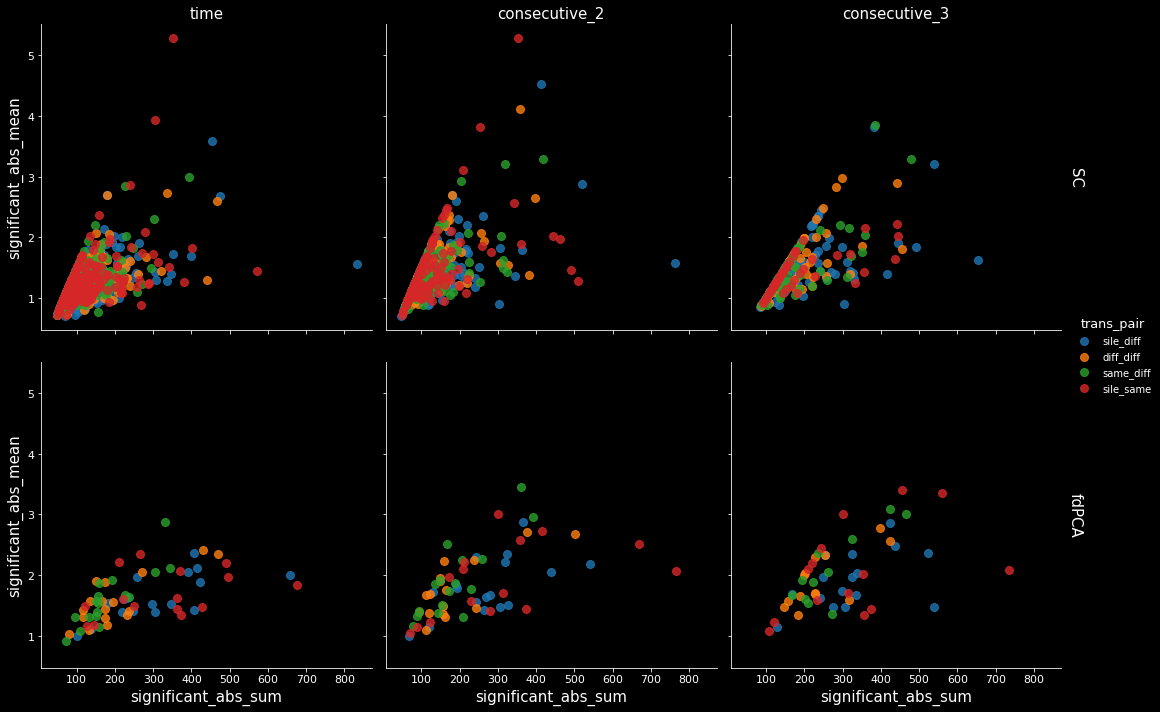

In [25]:
cols = ['time','consecutive_2', 'consecutive_3']
rows = ['SC', 'fdPCA']
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mean', data=aggDF,
               hue='trans_pair', row='analysis', col='mult_comp_corr',
               fit_reg=False, sharex=True, sharey=True,
               row_order=rows, col_order=cols)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

# selects multiple comparisons correction

## Single data points

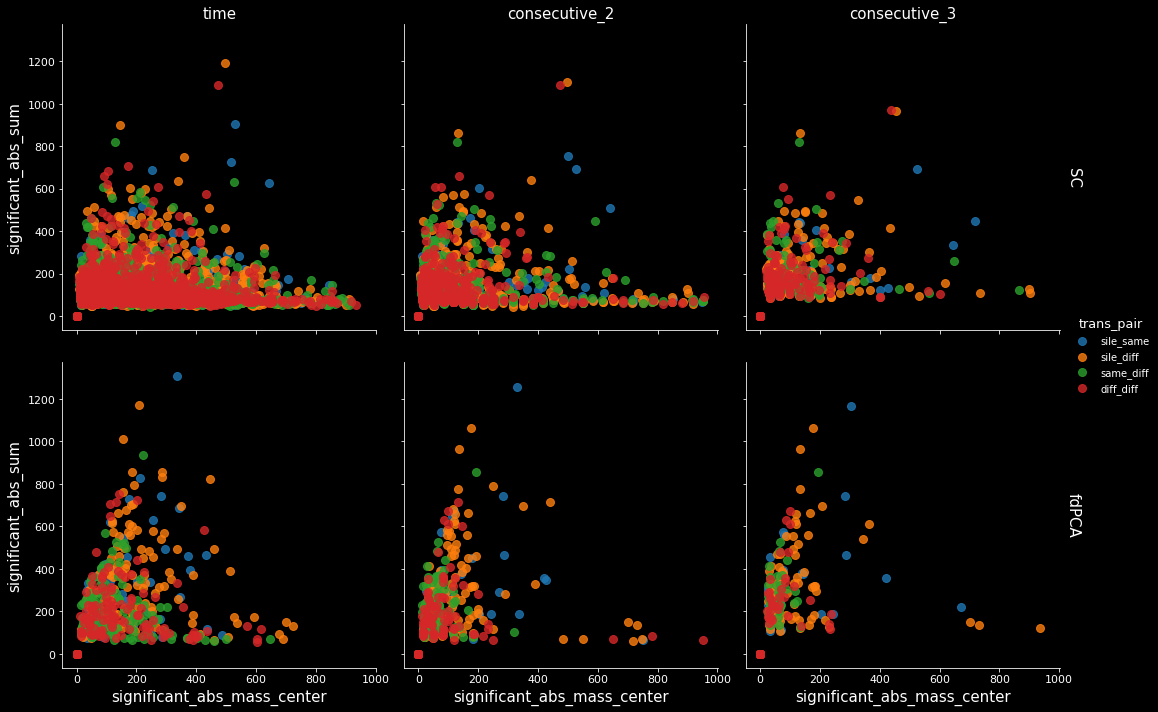

In [26]:
# per data poin
piv_idx = [col for col in classDF.columns if col not in ('metric', 'value')]
toplot = classDF.pivot_table(index=piv_idx, columns='metric', values='value', aggfunc='first').reset_index()

cols = ['time','consecutive_2', 'consecutive_3']
rows = ['SC', 'fdPCA']
amplitude = 'significant_abs_sum'
g = sns.lmplot(x='significant_abs_mass_center', y=amplitude, data=toplot,
               hue='trans_pair', row='analysis', col='mult_comp_corr',
               fit_reg=False, sharex=True, sharey=True,
               row_order=rows, col_order=cols)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")


## category mean per cell

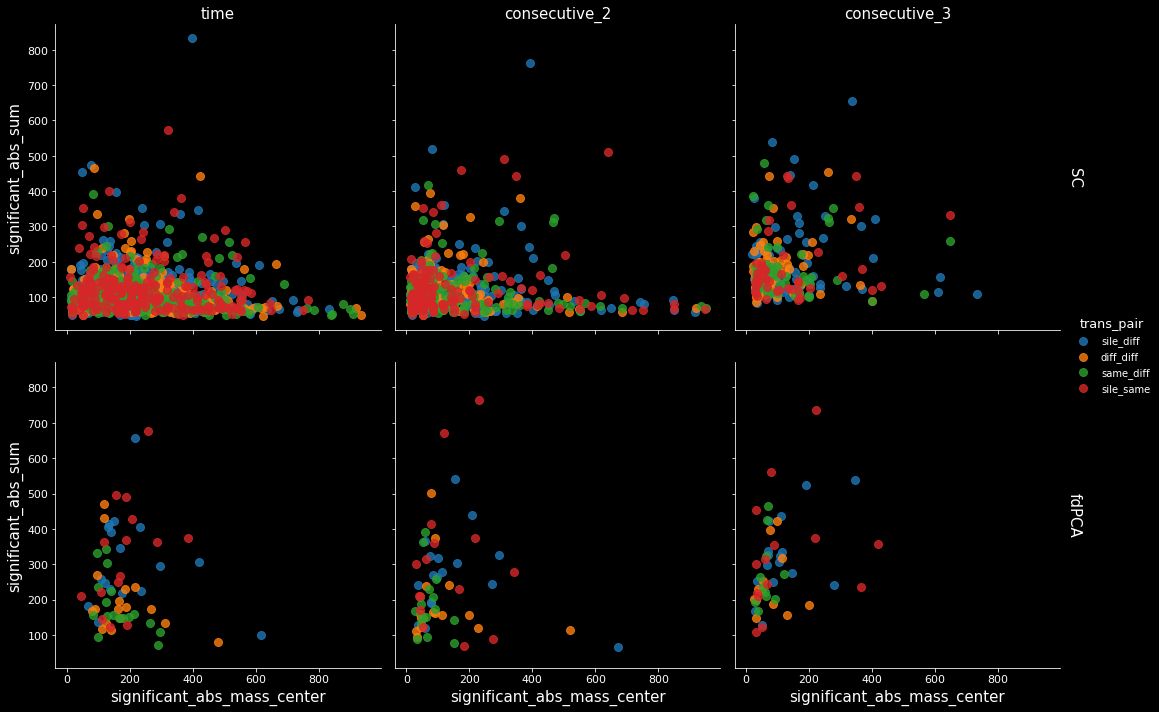

In [27]:
# per cell category mean
cols = ['time','consecutive_2', 'consecutive_3']
rows = ['SC', 'fdPCA']
amplitude = 'significant_abs_sum'
g = sns.lmplot(x='significant_abs_mass_center', y=amplitude, data=aggDF,
               hue='trans_pair', row='analysis', col='mult_comp_corr',
               fit_reg=False, sharex=True, sharey=True,
               row_order=rows, col_order=cols)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

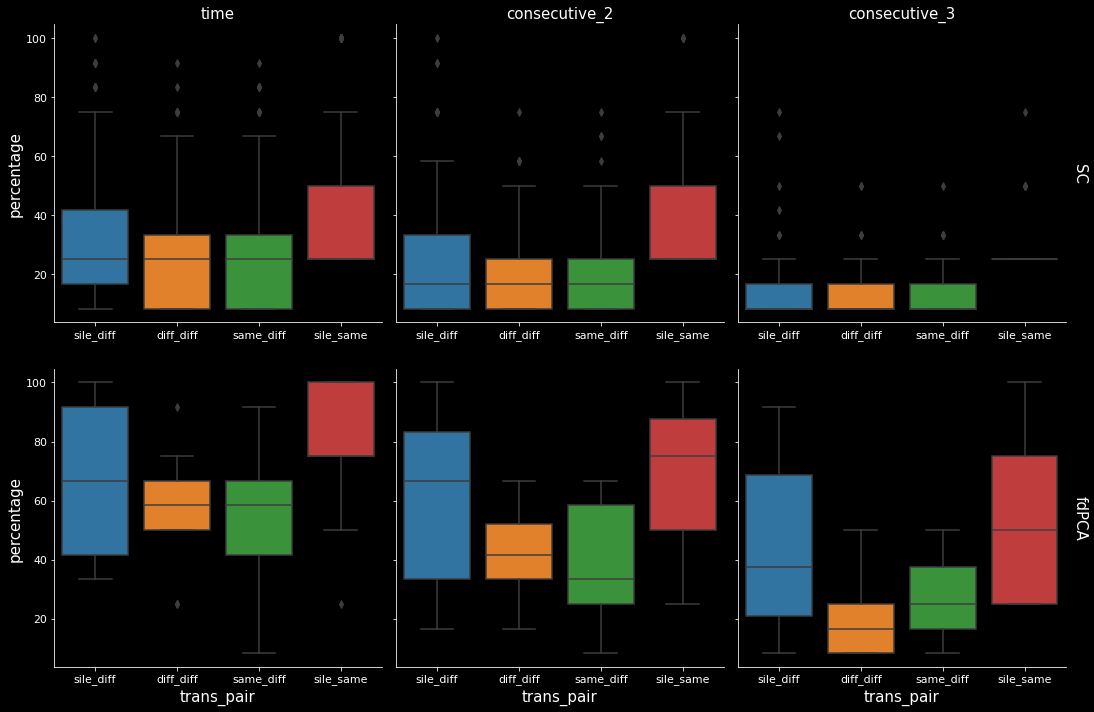

In [28]:
g = sns.catplot(kind='box',x='trans_pair', y='percentage', data=aggDF,
               row='analysis', col='mult_comp_corr', sharex=False, sharey=True,
               row_order=rows, col_order=cols)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")


# Same as before, considering every data point instead of the mean per cell
now lets attempt to do the same plots considering  individual combinations of cell/probe/trans_pairs
aditionally, for the percentages of significant, pool across all cell/probes

also, further filters out unused comparison corrections

In [29]:
print(classDF.columns)
correction = 'consecutive_3'
ff_comps = classDF.mult_comp_corr == correction
ff_analylis = classDF.analysis.isin(['SC', 'fdPCA'])

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
filtered = classDF.loc[ff_comps & ff_analylis, ord_cols]

good_cols = [col for col in ord_cols if col not in ['value']]
print('duplicates?: ', np.any(filtered.loc[:, good_cols].duplicated()))
print('nans?: ', any(filtered['value'].isna()))
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()
pivoted.head()

Index(['analysis', 'mult_comp_corr', 'region', 'context_pair', 'probe',
       'metric', 'value', 'id', 'trans_pair'],
      dtype='object')
duplicates?:  False
nans?:  False


metric,analysis,region,id,context_pair,trans_pair,probe,significant_abs_mass_center,significant_abs_mean,significant_abs_sum
0,SC,A1,AMT020a-02-1,0_1,sile_diff,2,0.0,0.0,0.0
1,SC,A1,AMT020a-02-1,0_1,sile_diff,3,0.0,0.0,0.0
2,SC,A1,AMT020a-02-1,0_1,sile_diff,4,0.0,0.0,0.0
3,SC,A1,AMT020a-02-1,0_1,sile_same,1,0.0,0.0,0.0
4,SC,A1,AMT020a-02-1,0_2,sile_diff,1,0.0,0.0,0.0


For each transition_pair category, calculates the mean metric, as well the the total number of values
(index x context_pair x probe), and the number of singificant values.

These numbers are categorized by region (A1 or PEG) and by analysis type (SC, dPCA).


In [30]:
# counts the total number of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values
# decimates the more numerous comparisons??

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]

agg_funcs = {'significant_abs_mass_center': [('lag_mean', nozero_mean)],
             amplitude: [('amplitude_mean', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['percent_signif'] = grouped.n_signif / grouped.total * 100

grouped

lag_mean  amplitude_mean  total  n_signif  \
analysis region trans_pair                                                
SC       A1     diff_diff    75.006244      189.981305   3048      71.0   
                same_diff    79.475199      189.232723   3048      58.0   
                sile_diff   127.775996      194.217579   3048      97.0   
                sile_same   110.425481      182.859911   1016      25.0   
         PEG    diff_diff   135.009291      201.080163   2148      64.0   
                same_diff   134.748956      191.104165   2148      60.0   
                sile_diff   143.454266      221.070534   2148      77.0   
                sile_same   173.983495      207.885581    716      29.0   
fdPCA    A1     diff_diff    61.124351      300.315536    108      16.0   
                same_diff    62.695339      303.291908    108      19.0   
                sile_diff   133.918455      347.211973    108      47.0   
                sile_same   121.576641      358.973782     36      16.0   
         PEG    diff_diff    93.546530      260.922666     96      18.0   
                same_diff    67.688093      274.106303     96      16.0   
                sile_diff   104.131293      304.161943     96      37.0   
                sile_same   135.152936      327.898934     32      13.0   

                            percent_signif  
analysis region trans_pair                  
SC       A1     diff_diff         2.329396  
                same_diff         1.902887  
                sile_diff         3.182415  
                sile_same         2.460630  
         PEG    diff_diff         2.979516  
                same_diff         2.793296  
                sile_diff         3.584730  
                sile_same         4.050279  
fdPCA    A1     diff_diff        14.814815  
                same_diff        17.592593  
                sile_diff        43.518519  
                sile_same        44.444444  
         PEG    diff_diff        18.750000  
                same_diff        16.666667  
                sile_diff        38.541667  
                sile_same        40.625000

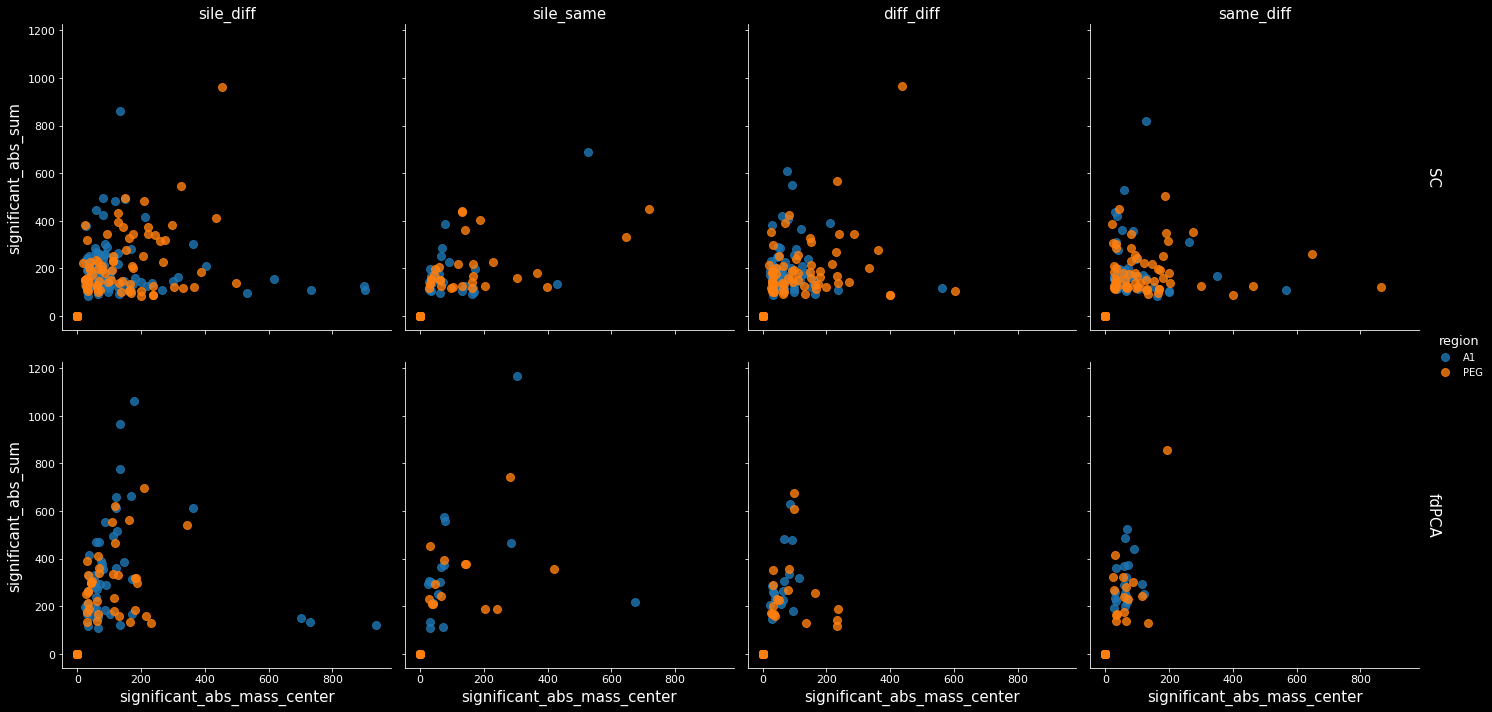

In [31]:
# removes zero-zero values, i.e. non singificnat values

rows = ['SC', 'fdPCA']
g = sns.lmplot(x='significant_abs_mass_center', y=amplitude, hue='region', data=pivoted,
               row='analysis', col='trans_pair',
               fit_reg=False, sharex=True, sharey=True,
               row_order=rows)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")


multiple comparisons correction  consecutive_3


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


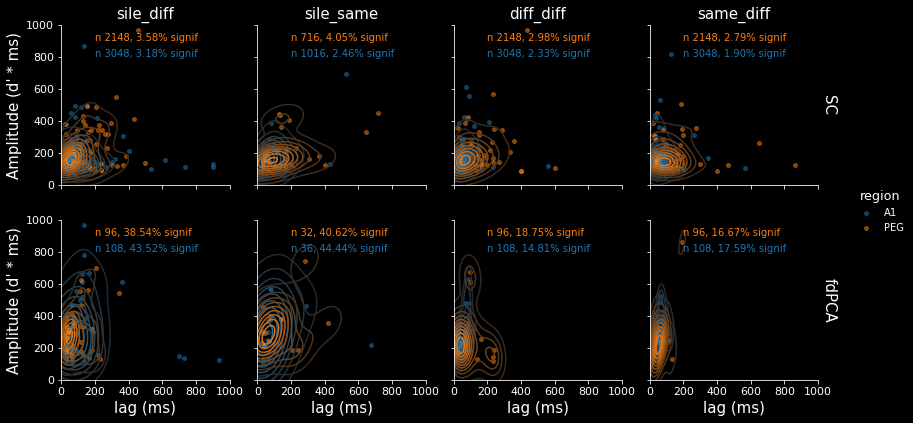

In [33]:
# grid with proportion anotations
print('multiple comparisons correction ', correction)
def anotated_nozero_scatter(x, y, **kws):
    total = x.shape[0]
    x = x[x>0]
    y = y[y>0]
    region = kws['label']
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=15, alpha=0.5, **kws)
    sns.kdeplot(x, y, ax=ax, **kws)
    ax.set_xlim(0,1000)
    ax.set_ylim(0,1000)

    offset = 0.8 if region == 'A1' else 0.9
    ax.text(.2, offset, f'n {total}, {percent_good:.2f}% signif', transform=ax.transAxes,  **kws)

# note that this ploting fuction uses the unfiltered dataframe, since it calculates the proportion of
# significant values
g = sns.FacetGrid(data=pivoted, row='analysis', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True)
g.map(anotated_nozero_scatter,'significant_abs_mass_center',amplitude)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_axis_labels('lag (ms)', "Amplitude (d' * ms)")
g.add_legend()
fig = g.fig
fig.tight_layout(rect=(0,0,0.98,0))


# explained variance plots

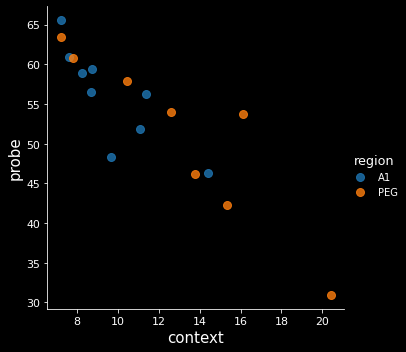

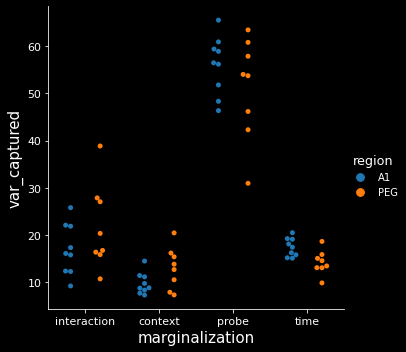

In [34]:
varDF = jl.load(Path('../data/210302_variance_explained_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))
varDF['region'] = [region_map[site] for site in varDF.siteid]
varDF.rename(columns={'cpt': 'interaction', 'ct':'context', 'pt':'probe', 't':'time'}, inplace=True)
# print(varDF)
g = sns.lmplot(x='context', y='probe', hue='region', data=varDF, fit_reg=False)
# g = sns.lmplot(x='interaction', y='probe', hue='region', data=varDF, fit_reg=False)

molten = varDF.melt(id_vars=['siteid', 'region'], var_name='marginalization', value_name='var_captured')
g = sns.catplot(kind='swarm', x='marginalization', y='var_captured', hue='region', data=molten, dodge=True)


# Parameter comparisons with significance tests
going over old parameter comparison between regions. Since I am no longer geting means of context_pairs and probe but
rather treating each id-trans_pair-probe as an obervation (and only those that are significant) the compoarisosn are no
longer paired. May the gods of statistics have mercy of my code.

### all together

In [57]:
amplitude = 'significant_abs_sum'
metrics = ['significant_abs_mass_center', amplitude]
id_vars = [col for col in pivoted.columns if col not in metrics]
catDF = pivoted.melt(id_vars=id_vars, value_vars=metrics,
                   var_name='metric', value_name='value')
catDF = catDF.loc[catDF.value > 0, :]

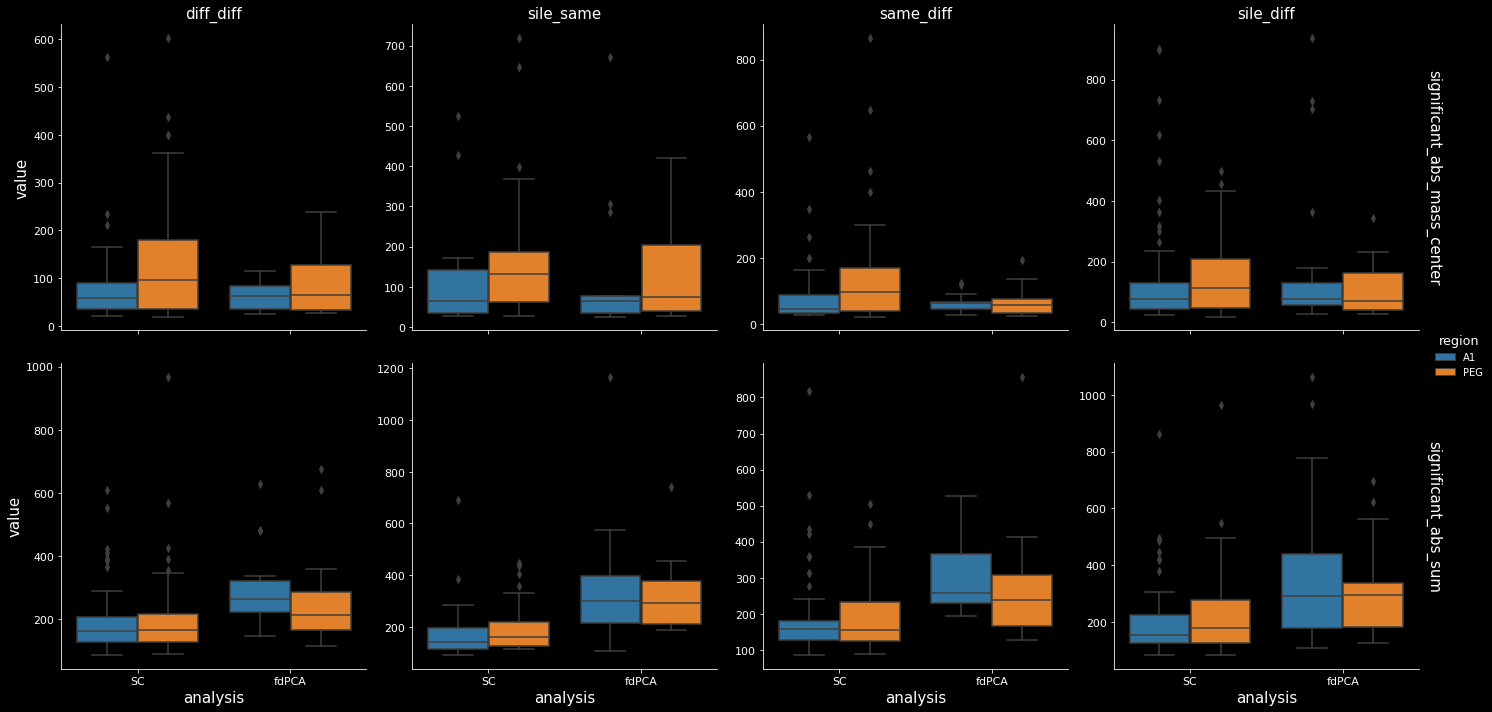

In [63]:
g = sns.catplot(kind='box',x='analysis', y='value', hue='region',
                row='metric', col='trans_pair',data=catDF, dodge=True,
                sharey=False)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

### between areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


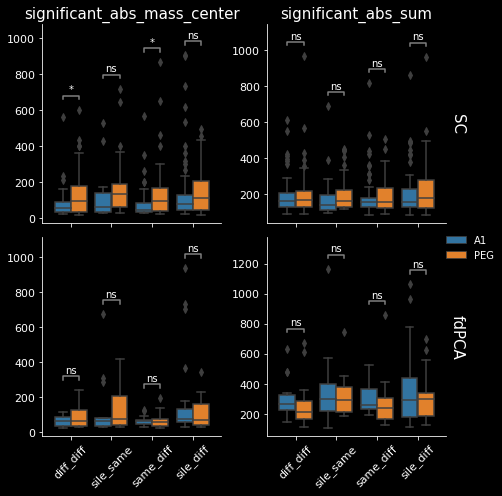

In [121]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

area_pairs = [(('diff_diff', 'A1'), ('diff_diff', 'PEG')),
              (('same_diff', 'A1'), ('same_diff', 'PEG'))]
area_pairs = [((trans, 'A1'), (trans, 'PEG')) for trans in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=area_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7,7)
fig.tight_layout(rect=(0,0,0.95,1))

### beteween transitions pairs, by area ...

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


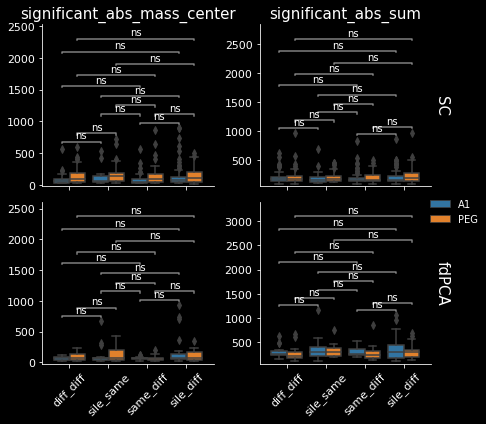

In [112]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

trans_pp = [((tp1, reg), (tp2, reg)) for (tp1, tp2), reg
            in itt.product(itt.combinations(catDF.trans_pair.unique(),2), catDF.region.unique())]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric', data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.tight_layout(rect=(0,0,0.95,1))

### between transition pairs, pooling areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


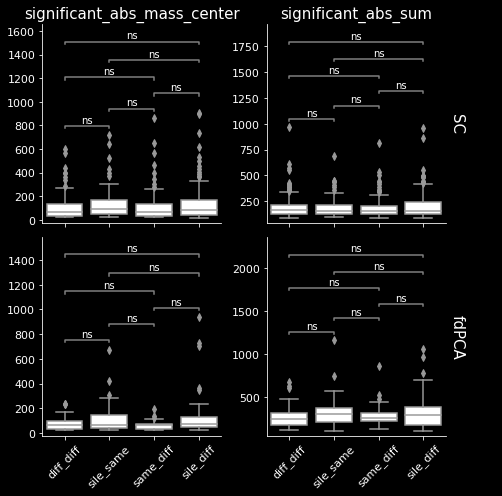

In [122]:
trans_ord = catDF.trans_pair.unique()
trans_pp = [(tp1, tp2) for tp1, tp2
            in itt.combinations(catDF.trans_pair.unique(),2)]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['white'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))

### between analysis types (SC, fdPCA)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


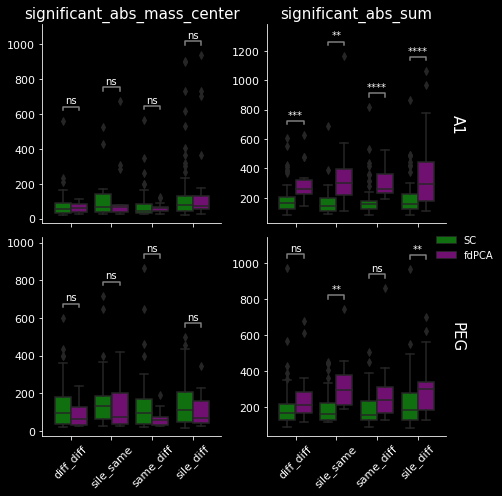

In [123]:

trans_ord = catDF.trans_pair.unique()
ana_ord = catDF.analysis.unique()
analysis_pairs =[((tp, 'SC'), (tp, 'fdPCA')) for tp in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['green', 'purple'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=ana_ord,
                            box_pairs=analysis_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='region', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='analysis')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))


# repeat some of these plots using the mean d' instead of integral.

In [124]:
amplitude = 'significant_abs_mean'
metrics = ['significant_abs_mass_center', amplitude]
id_vars = [col for col in pivoted.columns if col not in metrics]
catDF = pivoted.melt(id_vars=id_vars, value_vars=metrics,
                   var_name='metric', value_name='value')
catDF = catDF.loc[catDF.value > 0, :]

### between areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


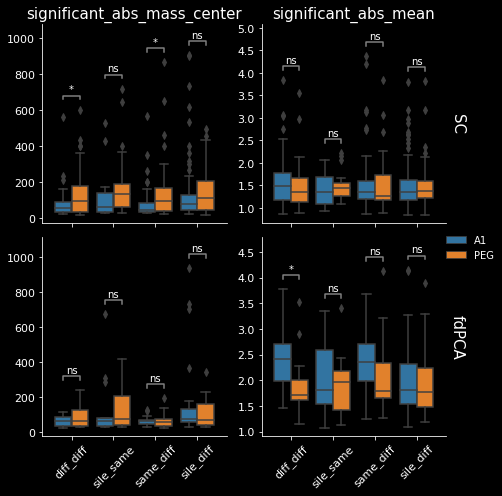

In [126]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

area_pairs = [(('diff_diff', 'A1'), ('diff_diff', 'PEG')),
              (('same_diff', 'A1'), ('same_diff', 'PEG'))]
area_pairs = [((trans, 'A1'), (trans, 'PEG')) for trans in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=area_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7,7)
fig.tight_layout(rect=(0,0,0.95,1))

### beteween transitions pairs, by area ...

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


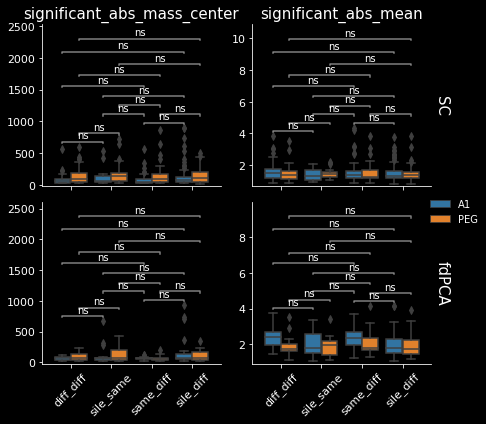

In [127]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

trans_pp = [((tp1, reg), (tp2, reg)) for (tp1, tp2), reg
            in itt.product(itt.combinations(catDF.trans_pair.unique(),2), catDF.region.unique())]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric', data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.tight_layout(rect=(0,0,0.95,1))

### between transition pairs, pooling areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


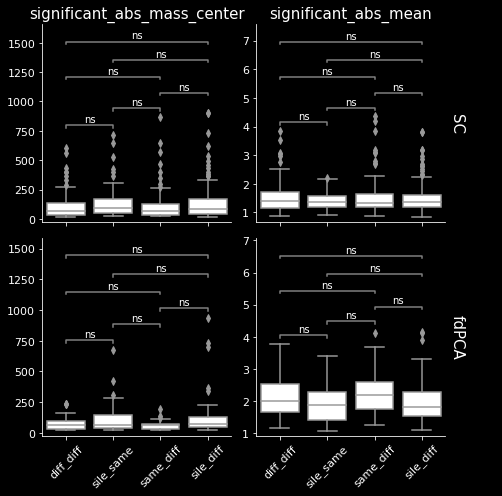

In [128]:
trans_ord = catDF.trans_pair.unique()
trans_pp = [(tp1, tp2) for tp1, tp2
            in itt.combinations(catDF.trans_pair.unique(),2)]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['white'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))

### between analysis types (SC, fdPCA)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


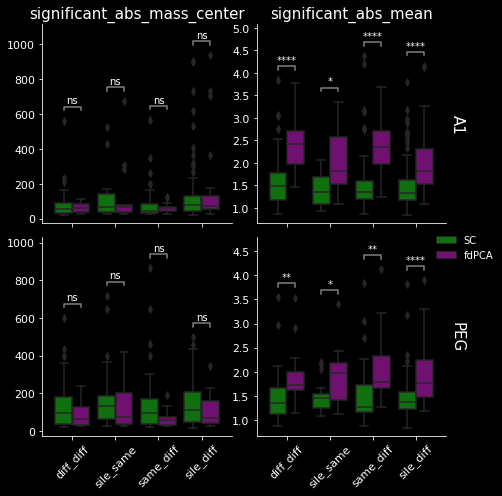

In [129]:

trans_ord = catDF.trans_pair.unique()
ana_ord = catDF.analysis.unique()
analysis_pairs =[((tp, 'SC'), (tp, 'fdPCA')) for tp in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['green', 'purple'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=ana_ord,
                            box_pairs=analysis_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='region', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='analysis')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))

